<img src = "images/Logo.png" width = 220, align = "left">

<h1 align=center><font size = 6><span style="color:blue">Multicollinearity</span></font></h1>
<h2 align=center><font size = 5>Lab Exercise 3.10</font></h2>
<h3 align=center><font size = 4><b>Advanced Machine Learning Made Easy<br></b><small>From Theory to Practice with NumPy and scikit-learn<br><i>Volume 1: Generalized Linear Models</i></font></h3>

## Introduction

In this lab exercise, the identification and consequences of multicollinearity will be explored, as well as, some methods to eliminate multicollinearity will be presented.

The following datasets will be used in this lab exercise:
- Blood pressure vs. age and weight already discussed in Lab exercise 2.3
- Blood pressure vs. multiple predictors
- Exercise vs. immune system
- Bodyfat dataset already discussed in Lab exercise 3.5
- Bodyfat percentage dataset

*Note:*<br>
Source of the dataset Blood pressure vs. multiple predictors: https://online.stat.psu.edu/onlinecourses/sites/stat501/files/data/bloodpress.txt <br>
Source of the Exercise vs. immune sytem: https://online.stat.psu.edu/onlinecourses/sites/stat501/files/data/exerimmun.txt <br>
Source of the Bodyfat dataset: https://rdrr.io/cran/isdals/man/bodyfat.html <br>
Source of the Bodyfat percentage dataset: http://lib.stat.cmu.edu/datasets/bodyfat

### Table of contents
1. [Visual presentation of a multicollinearity problem](#Visual)
2. [Detecting multicollinearity](#Detecting)
3. [Effect of (nearly) uncorrelated predictors](#Uncorrelated)
4. [Effect of highly correlated predictors](#Correlated)
5. [Reducing data-based multicollinearity](#Databased)
6. [Reducing structural-based multicollinearity](#Structurebased)
7. [Principal Components Regression](#PCR)
8. [Case study: Body fat percentage](#PcentBodyFat)

## 1. Visual presentation of a multicollinearity problem <a name="Visual"></a>

To have a better understanding of (multi)collinearity, let's visualize the consequence of an MLR with two highly correlated predictors, like in the case of Blood pressure vs. age and weight already discussed in Lab exercise 3.1. In that case, the Pearson correlation coefficient between predictors *Age* and *Weight* is 0.95.

As a first step, we import the required libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import eigh, inv, det, norm
from statsmodels.formula.api import ols
import os
%matplotlib inline

Then load the *Blood pressure vs. age and weight* (in the book referred to as *BloodPressure2*) dataset into a pandas dataframe.

In [2]:
data = pd.read_csv(os.path.join('data','BloodpressureAgeWeight.csv'))
X=np.array(data[["Age in years","Weight in pounds"]])
N,D=X.shape

As a next step, let's create the input and design matrix, respective the output vector from the pandas dataframe. Then we will produce the OLS regression plane for this input. Finally, we will add a small binomial random noise (with mean zero and standard errors of $\sigma_\text{Age}=2, \sigma_\text{Weight}=3$) to the original data, so a new sample, as a slight variant of the original data, is obtained. Then we will create the OLS model for this new sample, as well.

In [3]:
# Creating the design matrix and the weight vector
Xdot=np.insert(X,0,np.ones(N),axis=1)
y_=np.array(data["Systolic blood pressure"])[:,np.newaxis]
w_=inv(Xdot.T@Xdot)@Xdot.T@y_

# Creating the regression line between the input variables
w=np.sum((X[:,1]-X[:,1].mean())*(X[:,0]-X[:,0].mean()))/np.sum((X[:,0]-X[:,0].mean())**2)   # (1)
b=X[:,1].mean()-w*X[:,0].mean()                                                             # (2)

# Adding little noise to the input matrix and calculating the new weight vector
np.random.seed(10)
mean = [0, 0]
cov = [[4, 0], [0, 9]]
xn, yn = np.random.multivariate_normal(mean, cov, 11).T
Xn=X+np.array([xn,yn]).T
Xdotn=np.insert(Xn,0,np.ones(N),axis=1)
wn_=inv(Xdotn.T@Xdotn)@Xdotn.T@y_
Xn

array([[ 53.43055795, 176.99475951],
       [ 58.9832323 , 179.36379912],
       [ 65.55982888, 195.86400792],
       [ 73.21709705, 211.79653476],
       [ 63.65079958, 196.01287429],
       [ 76.40607475, 221.29907857],
       [ 56.05654816, 185.10480299],
       [ 61.89027523, 188.68589039],
       [ 65.27027376, 203.59019336],
       [ 43.84039023, 171.45361101],
       [ 68.51325541, 211.06681516]])

Finally, let's plot the original observations (blue points) and their projections (red points) on the plane of the input variables), respective the correlation line in the OLS plane (blue line), and its projection (red line). Then we shall plot both the OLS regression plane for the original data (with blue) and the OLS regression plane for the new sample (with purple).

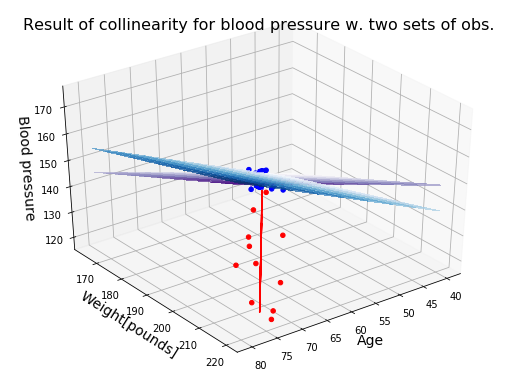

In [4]:
from matplotlib import cm
fig = plt.figure(figsize=(7, 5))
ax = Axes3D(fig)
ax.view_init(elev=36, azim=53)
ax.scatter(Xdot[:,1], Xdot[:,2], y_, c='b', alpha=1)
ax.scatter(Xdot[:,1], Xdot[:,2], 119*np.ones(N), c='r', alpha=1)
ax.plot(X[:,0],b+w*X[:,0],119*np.ones(N),c='r')
ax.plot(X[:,0],b+w*X[:,0],w_[0,0]+w_[1,0]*X[:,0]+w_[2,0]*(b+w*X[:,0]),c='b',lw=10)
# Creating the meshgrid for x (age),y(weigth) and calculating the value of z (surface)
xx, yy = np.meshgrid(np.arange(40,85,5), np.arange(165,225,5))
zz = w_[0,0]+w_[1,0]*xx+w_[2,0]*yy
surf = ax.plot_surface(xx, yy, zz, cmap=cm.Blues, linewidth=0, antialiased=False, alpha=0.7)
for i in range(N):
    ax.plot([Xdot[i,1],Xdot[i,1]],[Xdot[i,2],Xdot[i,2]],[y_[i,0],w_[0,0]+w_[1,0]*Xdot[i,1]+w_[2,0]*Xdot[i,2]])

# Creating the meshgrid for noisy x (age),y(weigth) and calculating the value of z (surface)
xx, yy = np.meshgrid(np.arange(40,85,5), np.arange(165,225,5))
zz = wn_[0,0]+wn_[1,0]*xx+wn_[2,0]*yy
surf = ax.plot_surface(xx, yy, zz, cmap=cm.Purples, linewidth=0, antialiased=False, alpha=0.7)
    
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Weight[pounds]', fontsize=14)
ax.set_zlabel('Blood pressure', fontsize=14)
ax.set_title('Result of collinearity for blood pressure w. two sets of obs.', fontsize=16)
plt.show() 

As can be seen, even a tiny variation in the sample will produce a noticeable different regression plane due to significant changes in the regression coefficient (they may even change the sign!). The azimuth and elevation for the 3D plot are set such that the angle between the two regression planes is clearly visible. 

**Note:** *This is analogous like saying that with highly correlated predictors the regression plane will be rotated around the correlation line with each new sample. It is obvious that we cannot use both predictors (*Age* and *Weight*) to obtain a good regression model that can be used to predict the blood pressure of a person.*

In [5]:
data=data.rename(index=str, columns={"Systolic blood pressure": "BloodPressure","Age in years":"Age",\
                                     "Weight in pounds":"Weight"})
result = ols(formula = 'BloodPressure ~ Age', data=data).fit()
print(result.summary(title='OLS Results for the "Blood pressure vs. Age and Weight" dataset with Weight removed'))
print("\nRMSE =",np.sqrt(result.mse_resid))

OLS Results for the "Blood pressure vs. Age and Weight" dataset with Weight removed
Dep. Variable:          BloodPressure   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     204.5
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.71e-07
Time:                        17:24:01   Log-Likelihood:                -26.402
No. Observations:                  11   AIC:                             56.80
Df Residuals:                       9   BIC:                             57.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.7055      6.452      9.098    

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


As can be seen, using only the *Age* as the predictors provides an impressive result with $R^2=0.96$ and RMSE=2.95. You should notice that the outcome is very different from what we obtained with the other dataset used in Lab exercise 2.3.
1. From Lab exercise 2.3 we have $\hat\beta_\text{Age}=0.97$, $R^2=0.43$, RMSE=17.31 (called under name of "Standard error of estimate")
2. From this datasat we have $\hat\beta_\text{Age}=1.46$, $R^2=0.96$, RMSE=2.95

## 2. Detecting multicollinearity <a name="Detecting"></a>

In this part we will examine how we can detect the presense of multicollearity, when there are more than two predictors.
For this, we load the *BloodPressureMLR* dataset (in the book referred to *BloodPressure*), a 3rd one, as a new research was conducted with more possible predictors.

**Note:** *Remember, the 2nd dataset with two predictors (Age and Weight) introduced in Lab exercise 3.1 was not useful due to high collinearity (in the end, we dropped the Weight predictor from the model and ended up in SLR). So, a 3rd research was conducted now, with more possible predictors that we will explore in this lab exercise.*

In [6]:
data = pd.read_csv(os.path.join('data','BloodPressureMLR.txt'),sep='\t')
data

,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
0,1,105,47,85.4,1.75,5.1,63,33
1,2,115,49,94.2,2.10,3.8,70,14
2,3,116,49,95.3,1.98,8.2,72,10
3,4,117,50,94.7,2.01,5.8,73,99
4,5,112,51,89.4,1.89,7.0,72,95
5,6,121,48,99.5,2.25,9.3,71,10
6,7,121,49,99.8,2.25,2.5,69,42
7,8,110,47,90.9,1.90,6.2,66,8
8,9,110,49,89.2,1.83,7.1,69,62
9,10,114,48,92.7,2.07,5.6,64,35


The dataset contains 20 observations on 20 individuals with high blood pressure. We have the following variables:
- blood pressure ($y$=*BP*, in mm Hg)
- age ($x_1$=*Age*, in years)
- weight ($x_2$=*Weight*, in kg)
- body surface area ($x_3$=*BSA*, in sq m)
- duration of hypertension ($x_4$=*Dur*, in years)
- basal pulse ($x_5$=*Pulse*, in beats per minute)
- stress index ($x_6$=*Stress*)

The goal is to determine if a relationship exists between blood pressure and age, weight, body surface area, duration of hypertension, pulse rate, and stress level.

For this reason, let's make a statistical summary of the variables:

In [7]:
data.describe()

,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,10.50000,114.000000,48.600000,93.090000,1.998000,6.430000,69.600000,53.35000
std,5.91608,5.428967,2.500526,4.294905,0.136482,2.145276,3.803046,37.08635
min,1.00000,105.000000,45.000000,85.400000,1.750000,2.500000,62.000000,8.00000
25%,5.75000,110.000000,47.000000,90.225000,1.897500,5.250000,67.750000,17.00000
50%,10.50000,114.000000,48.500000,94.150000,1.980000,6.000000,70.000000,44.50000
75%,15.25000,116.250000,49.250000,94.850000,2.075000,7.600000,72.000000,95.00000
max,20.00000,125.000000,56.000000,101.300000,2.250000,10.200000,76.000000,99.00000


We may also create the scatter plot matrix to visualize the relation between the variables.

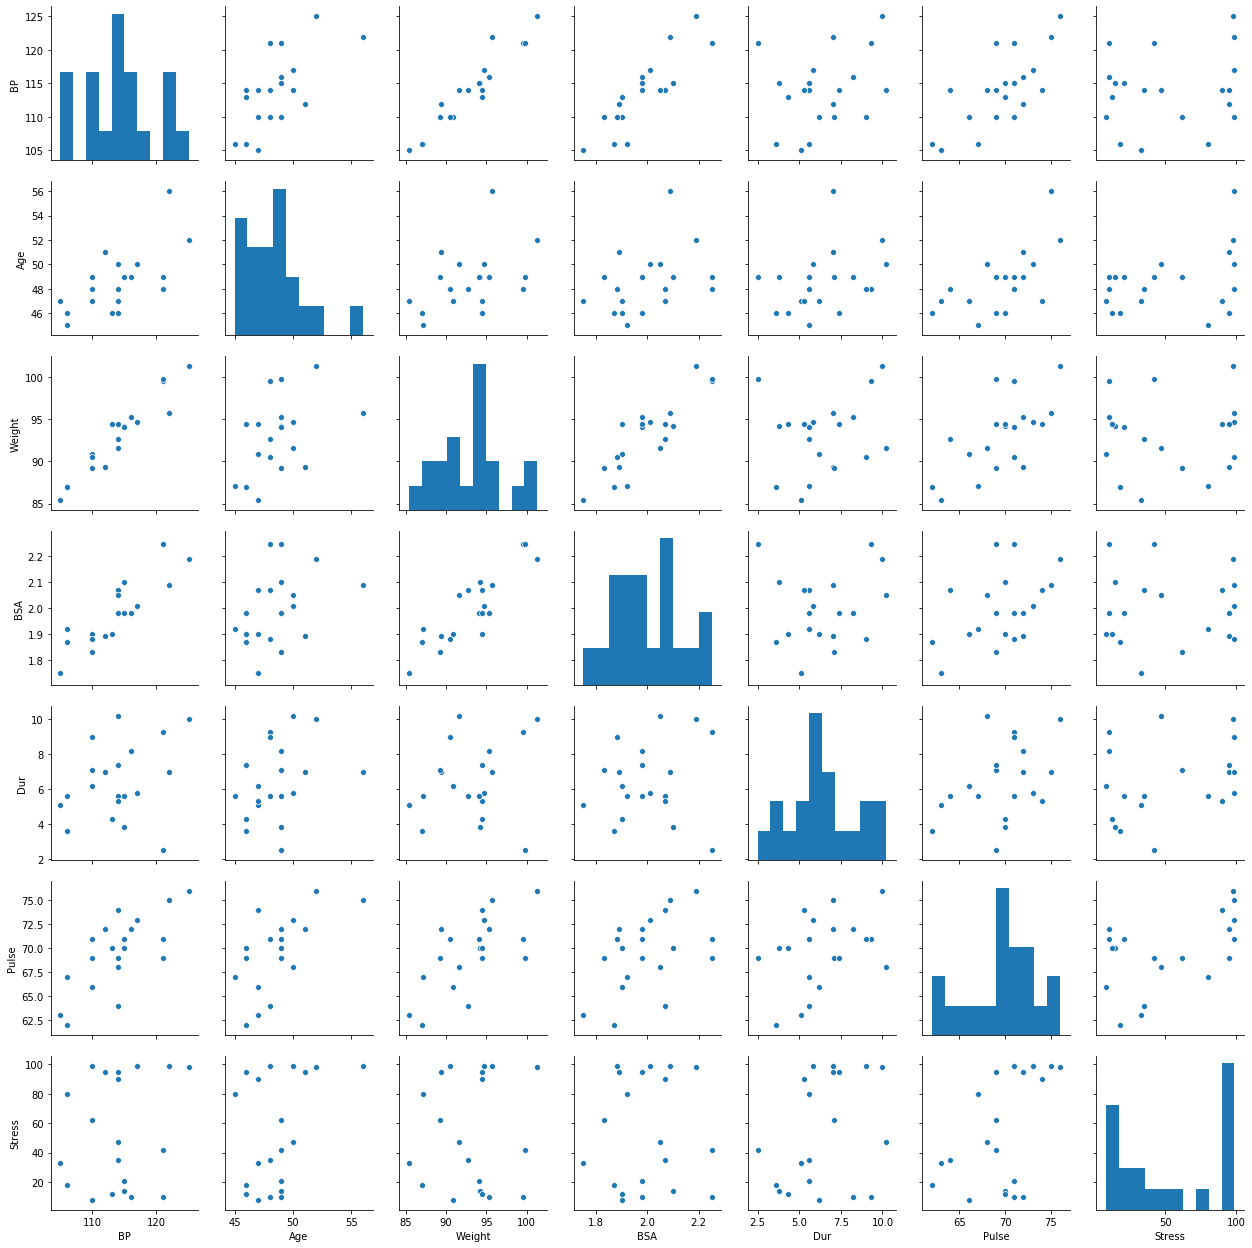

In [8]:
sns.pairplot(data.drop(columns='Pt'))
plt.show()

By analyzing the scatter plots, we may realize immediately that a positive linear relationship may exist between output variable blood pressure and input variables age, weight, and body surface area (BSA). But we may also find that there is a strong linear relation between some predictors, like weight and body surface area.

We may check with the correlation matrix, as well.

In [9]:
data.drop(columns=['Pt']).corr()

,BP,Age,Weight,BSA,Dur,Pulse,Stress
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
Age,0.659093,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224
Weight,0.950068,0.407349,1.000000,0.875305,0.200650,0.659340,0.034355
BSA,0.865879,0.378455,0.875305,1.000000,0.130540,0.464819,0.018446
Dur,0.292834,0.343792,0.200650,0.130540,1.000000,0.401514,0.311640
Pulse,0.721413,0.618764,0.659340,0.464819,0.401514,1.000000,0.506310
Stress,0.163901,0.368224,0.034355,0.018446,0.311640,0.506310,1.000000


Based on the scatter plot matrix and correlation matrix, the blood pressure (*BP*) seems to be dependent mostly on 
- *Age*,
- *Weight*, 
- *BSA*, 
- *Pulse*. 

On the other hand, there is a high correlation between predictors
- *Age* and *Pulse*
- *Weight* and *BSA*
- *Weight* and *Pulse*

But a very low correlation between predictors
- *Weight* and *Stress*
- *BSA* and *Stress*

Let's show the summary of the OLS for a model with all predictors using *statsmodels* library.

In [10]:
result = ols(formula = 'BP ~ Age + Weight + BSA + Dur + Pulse + Stress', data=data).fit()
print(result.summary(title='OLS Results for the "Blood pressure" dataset'))
print("\nRMSE =",np.sqrt(result.mse_resid))

                 OLS Results for the "Blood pressure" dataset                 
Dep. Variable:                     BP   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     560.6
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           6.40e-15
Time:                        17:24:18   Log-Likelihood:                -6.1033
No. Observations:                  20   AIC:                             26.21
Df Residuals:                      13   BIC:                             33.18
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.8705      2.557     -5.034      0.0

Although the R-squared value is very high, namely $R^2_{adj}=0.996$, the condition number is also very high. The F-statistics shows that our MLR model is a better fit than using the average of the output. However, when it comes to the individual t-statistics, several regression coefficients are not significantly different from zero.

Let's check the presence of multicollinearity using the variance inflation factors (VIF).

**Note**: *Variance inflation factors (VIF) were introduced in Lab Exercise 3.1. For more details, see the book.*

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X=np.array(data[['Age','Weight','BSA','Dur','Pulse','Stress']])
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)
#y_=np.array(dataFat['Fat'])[:,np.newaxis]

print("VIF for 'Age':",variance_inflation_factor(Xdot,1))
print("VIF for 'Weight':",variance_inflation_factor(Xdot,2))
print("VIF for 'BSA':",variance_inflation_factor(Xdot,3))
print("VIF for 'Dur':",variance_inflation_factor(Xdot,4))
print("VIF for 'Pulse':",variance_inflation_factor(Xdot,5))
print("VIF for 'Stress':",variance_inflation_factor(Xdot,6))

VIF for 'Age': 1.7628067217672179
VIF for 'Weight': 8.417035029633078
VIF for 'BSA': 5.328751470118894
VIF for 'Dur': 1.2373094205198356
VIF for 'Pulse': 4.4135751655972655
VIF for 'Stress': 1.8348453242645877


And indeed, two of the VIF values are above 5, while the third one has a VIF value close to 5.

We may conclude our analysis that there is a multicollinearity issue. Let's see what problems this might cause.

## 3. Effect of (nearly) uncorrelated predictors <a name="Uncorrelated"></a>

In the book, we proved that with uncorrelated predictors, both the regression coefficients and their standard errors remain the same as in the case of SLR. Although in our case, there are no two uncorrelated predictors, the Pearson correlation coefficient is very low between *BSA* and *Stress*, namely is only 0.018. So we might use this to illustrate the situation when we have uncorrelated predictors. 

So, let's create the MLR using *BSA* and *Stress*.

In [12]:
result = ols(formula = 'BP ~ BSA + Stress', data=data).fit()
print(result.summary(title='OLS Results for the "Blood pressure" dataset using only uncorrelated predictors'))
print("\nRMSE =",np.sqrt(result.mse_resid))

OLS Results for the "Blood pressure" dataset using only uncorrelated predictors
Dep. Variable:                     BP   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     28.72
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           3.53e-06
Time:                        17:24:18   Log-Likelihood:                -46.933
No. Observations:                  20   AIC:                             99.87
Df Residuals:                      17   BIC:                             102.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.2445      9.261      4.777      0.

According to the t-statistic, the regression coefficient for *Stress* is statistically zero (we cannot reject the null hypothesis). But for the moment we will not care about this. Instead, because the condition number is still large, let's calculate the VIF values.

In [13]:
X=np.array(data[['BSA','Stress']])
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)
print("VIF for 'BSA':",variance_inflation_factor(Xdot,1))
print("VIF for 'Stress':",variance_inflation_factor(Xdot,2))

VIF for 'BSA': 1.0003403832158666
VIF for 'Stress': 1.000340383215867


The VIF values are almost equal to one, indicating the absence of collinearity, so the condition number can be lowered by centering the data.

But we are not interested in this now. Instead, we want to see the regression coefficients and their standard errors in the case of SLR.

In [14]:
result = ols(formula = 'BP ~ BSA', data=data).fit()
print(result.summary(title='OLS Results for the "Blood pressure" dataset using only BSA as predictor'))
print("\nRMSE =",np.sqrt(result.mse_resid))

   OLS Results for the "Blood pressure" dataset using only BSA as predictor   
Dep. Variable:                     BP   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     53.93
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           8.11e-07
Time:                        17:24:18   Log-Likelihood:                -47.848
No. Observations:                  20   AIC:                             99.70
Df Residuals:                      18   BIC:                             101.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.1833      9.392      4.811      0.0

Because the two predictors are not totally uncorrelated, the regression coefficient is not exactly the same for *BSA* whether we use MLR or SLR, but are very close. The same is true for the standard error of the *BSA* regression coefficient.

A similar conclusion can be drawn for the *Stress* predictor (although the standard error is doubled, but still very low).

In [15]:
result = ols(formula = 'BP ~ Stress', data=data).fit()
print(result.summary(title='OLS Results for the "Blood pressure" dataset using only Stress as predictor'))
print("\nRMSE =",np.sqrt(result.mse_resid))

 OLS Results for the "Blood pressure" dataset using only Stress as predictor  
Dep. Variable:                     BP   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.4969
Date:                Wed, 18 Nov 2020   Prob (F-statistic):              0.490
Time:                        17:24:18   Log-Likelihood:                -61.429
No. Observations:                  20   AIC:                             126.9
Df Residuals:                      18   BIC:                             128.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.7200      2.193     51.389      0.0

Thus, we can conclude that if the predictors are nearly perfectly uncorrelated, then 
- the estimated regression coefficients are not affected if an additional predictor is included in the model
- the standard errors are not affected (i.e., the SLR and MLR provides the same standard errors). 
- Moreover, from the t-statistic, we can draw the same conclusion whether we use SLR or MLR.

## 4. Effect of highly correlated predictors <a name="Correlated"></a>

Now, let's see what we will observe when the predictors are highly correlated, like in the case of *Weight* and *BSA* with a Pearson correlation coefficient of 0.88. 

In [16]:
result = ols(formula = 'BP ~ Weight + BSA', data=data).fit()
print(result.summary(title='OLS Results for the "Blood pressure" dataset using only highly correlated predictors'))
print("\nRMSE =",np.sqrt(result.mse_resid))

OLS Results for the "Blood pressure" dataset using only highly correlated predictors
Dep. Variable:                     BP   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     83.54
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.61e-09
Time:                        17:24:18   Log-Likelihood:                -37.879
No. Observations:                  20   AIC:                             81.76
Df Residuals:                      17   BIC:                             84.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6534      9.392      0.602   

According to the t-statistic, the regression coefficient for *BSA* is statistically zero. But for the moment we will not care about this. Instead, because the condition number is still large, let's calculate the VIF values.

In [17]:
X=np.array(data[['Weight','BSA']])
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)
print("VIF for 'Weight':",variance_inflation_factor(Xdot,1))
print("VIF for 'BSA':",variance_inflation_factor(Xdot,2))

VIF for 'Weight': 4.276401239554405
VIF for 'BSA': 4.276401239554393


As can be seen, the VIF values are close to 5, so we have a collinearity issue. Let's see the effect of it by creating the individual SLR models.

In [18]:
result = ols(formula = 'BP ~ Weight', data=data).fit()
print(result.summary(title='OLS Results for the "Blood pressure" dataset using only Weight predictor'))
print("\nRMSE =",np.sqrt(result.mse_resid))

   OLS Results for the "Blood pressure" dataset using only Weight predictor   
Dep. Variable:                     BP   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     166.9
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.53e-10
Time:                        17:24:18   Log-Likelihood:                -38.409
No. Observations:                  20   AIC:                             80.82
Df Residuals:                      18   BIC:                             82.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2053      8.663      0.255      0.8

As can be seen, the regression coefficient for *Weight* is about 20% higher for SLR than for MLR. The difference is even higher for the *BSA* predictor.

In [19]:
result = ols(formula = 'BP ~ BSA', data=data).fit()
print(result.summary(title='OLS Results for the "Blood pressure" dataset using only BSA predictor'))
print("\nRMSE =",np.sqrt(result.mse_resid))

    OLS Results for the "Blood pressure" dataset using only BSA predictor     
Dep. Variable:                     BP   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     53.93
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           8.11e-07
Time:                        17:24:18   Log-Likelihood:                -47.848
No. Observations:                  20   AIC:                             99.70
Df Residuals:                      18   BIC:                             101.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.1833      9.392      4.811      0.0

We may conclude the followings:
1. When predictor variables are correlated, the estimated regression coefficient of any one variable depends on which other predictor variables are included in the model. For example, if *BSA* is the only predictor included in our model, we claim that for every additional one square meter increase in body surface area (BSA), blood pressure (BP) increases by 34.4 mm Hg. On the other hand, if *Weight* and *BSA* are both included in our model, we claim that for every additional one square meter increase in body surface area (BSA), holding weight constant, blood pressure (BP) increases by only 5.83 mm Hg. That is a huge difference!
2. When predictor variables are correlated, the precision of the estimated regression coefficients decreases as more predictor variables are added into the model. For example, the standard error for *Weight* regression coefficient is 0.093 in SLR and 0.193 in MLR, while the standard error for *BSA* regression coefficient is 4.690 in SLR and 6.063 in MLR.
3. When predictor variables are correlated, hypothesis tests for regression coefficients may yield different conclusions depending on which predictor variables are in the model. For example, t-statistic for estimated regression coefficient of *BSA* is significantly non-zero for SLR (p=0.000), but significantly zero for MLR (p=0.350). 

## 5. Reducing data-based multicollinearity <a name="Databased"></a>

One way of reducing data-based multicollinearity is to remove one or more of the violating predictors from the regression model. Another way is to collect additional data under different experimental or observational conditions. We will use the first method in this lab exercise.

One way to figure out which predictors shall be removed is to look at the Pearson correlation coefficients. Because *Weight* is highly correlated with both *BSA* and *Pulse* (0.875305, respective 0.659340) we might want to remove *Weight*. On the other hand, there is a high correlation between *Age* and *Pulse* (0.618764), so we might want to remove one of them, as well.

We can choose to remove either predictor from the model. The decision of which one to remove is often a scientific or practical one. For example, if the researchers here are interested in using their final model to predict the blood pressure of future individuals, their choice should be clear. Which of the two measurements — body surface area or weight — do you think would be easier to obtain? If weight is an easier measurement to obtain than body surface area, then the researchers would be well-advised to remove *BSA* from the model and leave *Weight* in the model.

So let's create a linear model by removing two predictors: *BSA* and *Pulse*

In [20]:
result = ols(formula = 'BP ~ Age + Weight + Dur + Stress', data=data).fit()
print(result.summary(title='OLS Results for the "Blood pressure" dataset using (mostly) uncorrelated predictors'))
print("\nRMSE =",np.sqrt(result.mse_resid))

OLS Results for the "Blood pressure" dataset using (mostly) uncorrelated predictors
Dep. Variable:                     BP   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     458.3
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.76e-15
Time:                        17:24:18   Log-Likelihood:                -13.562
No. Observations:                  20   AIC:                             37.12
Df Residuals:                      15   BIC:                             42.10
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.8698      3.195     -4.967    

Because the condition number is high, let's check the variance inflation factors.

In [21]:
X=np.array(data[['Age','Weight','Dur','Stress']])
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)
print("VIF for 'Age':",variance_inflation_factor(Xdot,1))
print("VIF for 'Weight':",variance_inflation_factor(Xdot,2))
print("VIF for 'Dur':",variance_inflation_factor(Xdot,3))
print("VIF for 'Stress':",variance_inflation_factor(Xdot,4))

VIF for 'Age': 1.4682447142238835
VIF for 'Weight': 1.2346529986777202
VIF for 'Dur': 1.2000596473516962
VIF for 'Stress': 1.2411166843349961


The VIF values do not indicate a multicollinearity issue. Thus, centering the data should resolve the condition number issue.

On the other hand, from the t-statistic, we can infer that the regression coefficients for *Dur* and *Stress* are not significantly different from zero. So let's create another model with centered data using only two predictors: *Age* and *Weight*.

To do this, first, we center the predictors.

In [22]:
data0=data-data.mean()
data0['BP']=data['BP']
data0

,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
0,-9.5,105,-1.6,-7.69,-0.248,-1.33,-6.6,-20.35
1,-8.5,115,0.4,1.11,0.102,-2.63,0.4,-39.35
2,-7.5,116,0.4,2.21,-0.018,1.77,2.4,-43.35
3,-6.5,117,1.4,1.61,0.012,-0.63,3.4,45.65
4,-5.5,112,2.4,-3.69,-0.108,0.57,2.4,41.65
5,-4.5,121,-0.6,6.41,0.252,2.87,1.4,-43.35
6,-3.5,121,0.4,6.71,0.252,-3.93,-0.6,-11.35
7,-2.5,110,-1.6,-2.19,-0.098,-0.23,-3.6,-45.35
8,-1.5,110,0.4,-3.89,-0.168,0.67,-0.6,8.65
9,-0.5,114,-0.6,-0.39,0.072,-0.83,-5.6,-18.35


Then print out the OLS results using *statsmodels* library.

In [23]:
result = ols(formula = 'BP ~ Age + Weight', data=data0).fit()
print(result.summary(title='OLS Results for the "Blood pressure" dataset using only Age and Weight predictors'))
print("\nRMSE =",np.sqrt(result.mse_resid))

OLS Results for the "Blood pressure" dataset using only Age and Weight predictors
Dep. Variable:                     BP   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     978.2
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           2.81e-18
Time:                        17:24:18   Log-Likelihood:                -14.157
No. Observations:                  20   AIC:                             34.31
Df Residuals:                      17   BIC:                             37.30
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    114.0000      0.119    957.071      

Comparing this model with only two predictors *Age* and *Weight* to the original one (using all the predictors from the database), we may conclude that the adjusted R-squared value remained almost the same ($R^2_{adj}=0.990$ vs. 0.996), while the RMSE increased only slightly (from 0.41 to 0.53). 

This is a good compromise if we think of what we gained on the other hand. Now, the accuracy of the estimated regression coefficients is better, resulting in narrower confidence intervals. 

Although for *Age* we have almost similar values 
- $\hat\beta_{Age}=0.7083$  and $S_{\hat\beta_{Age}}=0.054$ vs. $\hat\beta_{Age}=0.7033$ and $S_{\hat\beta_{Age}}=0.050$,

in case of *Weight* we have 
- $S_{\hat\beta_{Weight}}=1.0330$ and $S_{\hat\beta_{Weight}}=0.031$ vs. $S_{\hat\beta_{Weight}}=0.9699$ and $S_{\hat\beta_{Weight}}=0.063$.

Thus, for *Weight*, while the regression coefficient did not change significantly from SLR to MLR, the standard error was almost doubled.

Finally, we can check the variance inflation factors.

In [24]:
X=np.array(data0[['Age','Weight']])
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)
print("VIF for 'Age':",variance_inflation_factor(Xdot,1))
print("VIF for 'Weight':",variance_inflation_factor(Xdot,2))

VIF for 'Age': 1.1989450542463727
VIF for 'Weight': 1.1989450542463727


Now, both the condition number and the VIF values indicate the lack of colliniearity. Thus, with the new set of observations, we could build a model that can predict the blood pressure of a person based on the age and weight of that person without the multicollinearity issue. As such, the confidence intervals are narrower.

## 6. Reducing structural-based multicollinearity <a name="Structurebased"></a>

Structural multicollinearity is a mathematical artifact caused by creating new predictors from other predictors, like in the case of polynomial regression (which we will discuss in detail in a later exercise).

Now, let's check what is the impact of exercise on the human immune system? Here, in a simplistic way, we quantify the amount of exercise by measuring the "maximal oxygen uptake", and quantify the quality of one's immune system by measuring the amount of "immunoglobin in his or her blood". Thus, we end up answering the following research question: "How is the amount of immunoglobin in the blood (y) related to maximal oxygen uptake (x)?"

For this reason, let's load the *Exercise* system dataset.

In [25]:
data = pd.read_csv(os.path.join('data','Exercise.csv'),sep=';')
data

,igg,oxygen
0,881,34.6
1,1290,45.0
2,2147,62.3
3,1909,58.9
4,1282,42.5
5,1530,44.3
6,2067,67.9
7,1982,58.5
8,1019,35.6
9,1651,49.6


Let's create a scatter plot of the observations.

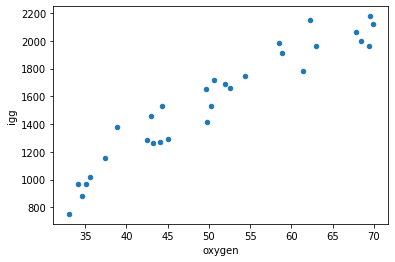

In [26]:
data.plot.scatter(y='igg',x='oxygen')

And print out the summary of the OLS using *statsmodels* library.

In [27]:
result = ols(formula = 'igg ~ oxygen', data=data).fit()
print(result.summary(title='OLS Results for the "Exercise" dataset'))
print("\nRMSE =",np.sqrt(result.mse_resid))

                    OLS Results for the "Exercise" dataset                    
Dep. Variable:                    igg   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     287.2
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           2.97e-16
Time:                        17:24:19   Log-Likelihood:                -186.33
No. Observations:                  30   AIC:                             376.7
Df Residuals:                      28   BIC:                             379.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -100.3454    100.450     -0.999      0.3

We might be happy with the result by looking at the R-squared value of 0.91. But looking at the scatter plot below we might have an insight that a quadratic function might be a better approach.

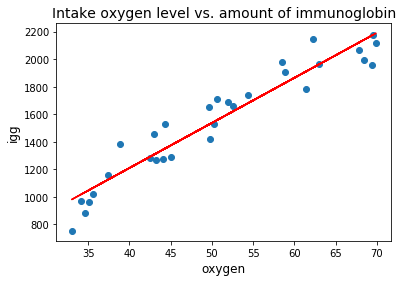

In [28]:
plt.scatter(data['oxygen'],data['igg'])
plt.plot(data['oxygen'],result.predict(data['oxygen']),c='r')
plt.xlabel('oxygen',fontsize=12)
plt.ylabel('igg',fontsize=12)
plt.title('Intake oxygen level vs. amount of immunoglobin',fontsize=14)
plt.show()

So, let's create another predictor, which is the square of the *oxygen* predictor.

In [29]:
data['oxygen2']=data['oxygen']*data['oxygen']
data

,igg,oxygen,oxygen2
0,881,34.6,1197.16
1,1290,45.0,2025.00
2,2147,62.3,3881.29
3,1909,58.9,3469.21
4,1282,42.5,1806.25
5,1530,44.3,1962.49
6,2067,67.9,4610.41
7,1982,58.5,3422.25
8,1019,35.6,1267.36
9,1651,49.6,2460.16


Let's print out the OLS results using the *statsmodels* library.

In [30]:
result = ols(formula = 'igg ~ oxygen + oxygen2', data=data).fit()
print(result.summary(title='OLS Results for the "Exercise" dataset using a quadratic function'))
print("\nRMSE =",np.sqrt(result.mse_resid))

      OLS Results for the "Exercise" dataset using a quadratic function       
Dep. Variable:                    igg   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     203.2
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           5.33e-17
Time:                        17:24:19   Log-Likelihood:                -181.01
No. Observations:                  30   AIC:                             368.0
Df Residuals:                      27   BIC:                             372.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1464.4042    411.401     -3.560      0.0

Looking at the OLS results, we can see that the R-squared value slightly increased, while the RMSE slightly decreased. So yes, our insight seems to be good. We may check this visually, as well.

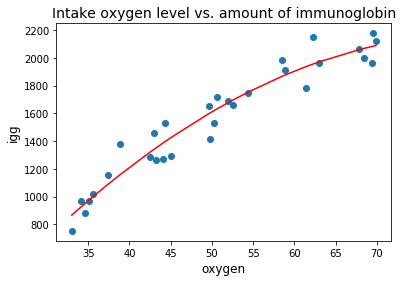

In [31]:
plt.scatter(data['oxygen'],data['igg'])
plt.plot(data.sort_values(by='oxygen')['oxygen'],result.predict(data.sort_values(by='oxygen')[['oxygen','oxygen2']]),c='r')
plt.xlabel('oxygen',fontsize=12)
plt.ylabel('igg',fontsize=12)
plt.title('Intake oxygen level vs. amount of immunoglobin',fontsize=14)
plt.show()

As can be seen, the quadratic function is a better fit than the linear one. <br>
However, the condition number is high. Thus, we might have a collinearity issue. Let's check the VIF values.

In [32]:
X=np.array(data[['oxygen','oxygen2']])
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)
print("VIF for 'oxygen':",variance_inflation_factor(Xdot,1))
print("VIF for 'oxygen2':",variance_inflation_factor(Xdot,2))

VIF for 'oxygen': 99.94261307344864
VIF for 'oxygen2': 99.94261307344864


As. can be seen, the VIF values are extremely high, indicating severe collinearity issues. We might check the Pearson correlation coefficients, as well.

In [33]:
data.corr()

,igg,oxygen,oxygen2
igg,1.000000,0.954552,0.933475
oxygen,0.954552,1.000000,0.994985
oxygen2,0.933475,0.994985,1.000000


As can be seen, the correlation coefficient between the original predictor and its square is extremely high, namely 0.995. This can be also checked visually.

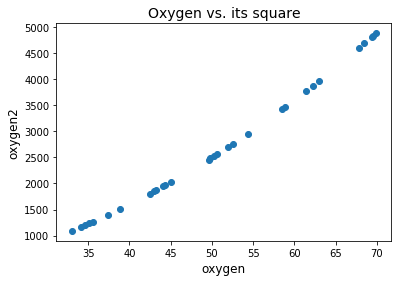

In [34]:
plt.scatter(data['oxygen'],data['oxygen2'])
plt.xlabel('oxygen',fontsize=12)
plt.ylabel('oxygen2',fontsize=12)
plt.title('Oxygen vs. its square',fontsize=14)
plt.show()

Although you might want to drop the artificially created predictor due to high collinearity, this is not a good idea. After all, we included just because we see both visually and through the goodness of fit measures that a better model can be obtained using this newly created predictor.

One way to get rid of the collinearity issue if we center the data first, and then we create the squared value.

In [35]:
data0=data-data.mean()
data0['igg']=data['igg']
data0['oxygen2']=data0['oxygen']*data0['oxygen']
data0

,igg,oxygen,oxygen2
0,881,-16.036667,257.174678
1,1290,-5.636667,31.772011
2,2147,11.663333,136.033344
3,1909,8.263333,68.282678
4,1282,-8.136667,66.205344
5,1530,-6.336667,40.153344
6,2067,17.263333,298.022678
7,1982,7.863333,61.832011
8,1019,-15.036667,226.101344
9,1651,-1.036667,1.074678


Now, let's check the correlation coefficients for the centered data.

In [36]:
data0.corr()

,igg,oxygen,oxygen2
igg,1.000000,0.954552,0.050662
oxygen,0.954552,1.000000,0.219518
oxygen2,0.050662,0.219518,1.000000


As we can see, the Pearson correlation coefficient between the two predictors dropped to 0.22. We can check this visually, as well.

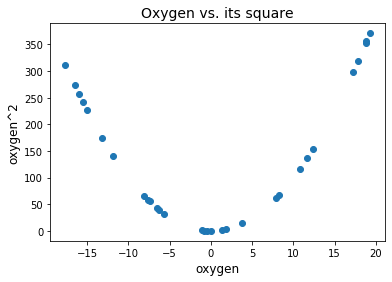

In [37]:
plt.scatter(data0['oxygen'],data0['oxygen2'])
plt.xlabel('oxygen',fontsize=12)
plt.ylabel('oxygen^2',fontsize=12)
plt.title('Oxygen vs. its square',fontsize=14)
plt.show()

Although the Pearson correlation coefficient also dropped between the response variable and square of the original predictor, being now only 0.05, we may still want to use both predictors in the OLS to create our improved prediction.

In [38]:
result = ols(formula = 'igg ~ oxygen + oxygen2', data=data0).fit()
print(result.summary(title='OLS Results for the "Exercise" dataset using an improved quadratic function'))
print("\nRMSE =",np.sqrt(result.mse_resid))

 OLS Results for the "Exercise" dataset using an improved quadratic function  
Dep. Variable:                    igg   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     203.2
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           5.33e-17
Time:                        17:24:21   Log-Likelihood:                -181.01
No. Observations:                  30   AIC:                             368.0
Df Residuals:                      27   BIC:                             372.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1632.1962     29.349     55.614      0.0

As we can see, the results are the same (R-squared and RMS value, as well as the regression coefficients and the standard errors). However, the condition number is now within the threshold. We may check the absence of collinearity with the VIF values.

In [39]:
X=np.array(data0[['oxygen','oxygen2']])
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)
print("VIF for 'oxygen':",variance_inflation_factor(Xdot,1))
print("VIF for 'oxygen2':",variance_inflation_factor(Xdot,2))

VIF for 'oxygen': 1.050627752640113
VIF for 'oxygen2': 1.050627752640113


And yes, the variance inflation factors are very close to 1, indicating the absence of the collinearity. Thus, we solved the structural-based collinearity issue.

## 7. Principal Components Regression <a name="PCR"></a>

There are cases when removing one predictor is not the best option when it comes to solving multicollinearity issues.

### Multiple Linear Regression

It is expensive and cumbersome to determine the body fat in humans as it involves immersion of the person in the water. This dataset provides information on body fat, triceps skinfold thickness, thigh circumference, and mid-arm circumference for twenty healthy females aged 20 to 34. It is desirable if a model could provide reliable predictions of the amount of body fat since the measurements needed for the predictor variables are easy to obtain. 

Let's start our investigation by loading the dataset into a *pandas* dataframe.

In [40]:
dataFat = pd.read_csv(os.path.join('data','bodyfat.csv'),sep=',')
dataFat

,Nr,Fat,Triceps,Thigh,Midarm
0,1,11.9,19.5,43.1,29.1
1,2,22.8,24.7,49.8,28.2
2,3,18.7,30.7,51.9,37.0
3,4,20.1,29.8,54.3,31.1
4,5,12.9,19.1,42.2,30.9
5,6,21.7,25.6,53.9,23.7
6,7,27.1,31.4,58.5,27.6
7,8,25.4,27.9,52.1,30.6
8,9,21.3,22.1,49.9,23.2
9,10,19.3,25.5,53.5,24.8


where 
- *Fat*: based on the immersion method, expressed as a percent of total weight
- *Triceps*: a measure of the triceps skinfold thickness in millimeters
- *Thigh*: thigh circumference in centimeters
- *Midarm*: mid-arm circumference in centimeters

The data is based on 20 female subjects, between the ages of 25-34 years. We should notice intuitively, that as any of the predictor variables increase, we should also see an increase in the response variable.

Let's print out the statistical summary.

In [41]:
dataFat.describe()

,Nr,Fat,Triceps,Thigh,Midarm
count,20.00000,20.000000,20.000000,20.000000,20.000000
mean,10.50000,20.195000,25.305000,51.170000,27.620000
std,5.91608,5.106186,5.023259,5.234612,3.647147
min,1.00000,11.700000,14.600000,42.200000,21.300000
25%,5.75000,17.050000,21.500000,47.775000,24.750000
50%,10.50000,21.200000,25.550000,52.000000,27.900000
75%,15.25000,24.275000,29.900000,54.625000,30.025000
max,20.00000,27.200000,31.400000,58.600000,37.000000


We may also create a scatter plot matrix.

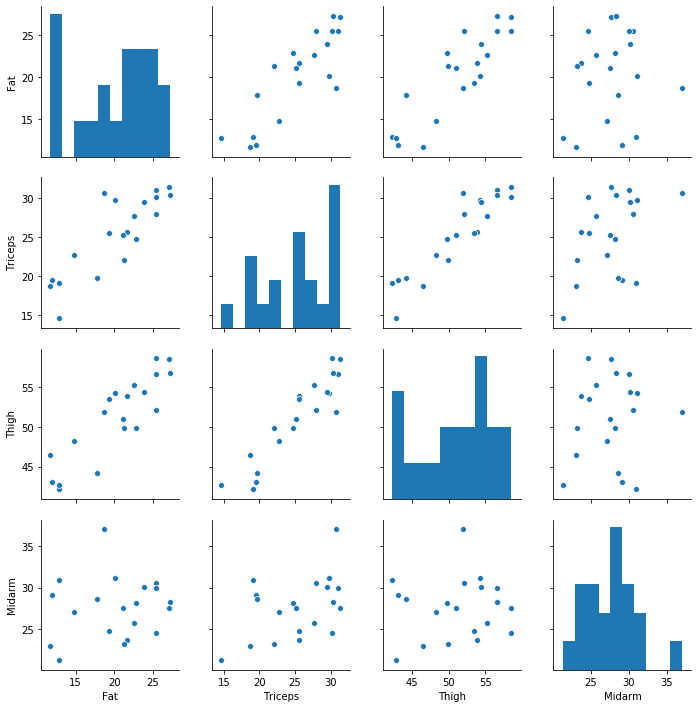

In [42]:
import seaborn as sns
sns.pairplot(dataFat.drop(columns='Nr'))
plt.show()

From the above scatter plot, it is clear that there is a linear relation between *Fat* and *Triceps*, respective between *Fat* and *Thigh*, but not between *Fat* and *Midarm*. However, it is also clear that there is a linear relationship between two input variables, namely *Triceps* and *Thigh*. We may check this with the correlation matrix.

In [43]:
dataFat.drop(columns=['Nr']).corr()

,Fat,Triceps,Thigh,Midarm
Fat,1.000000,0.843265,0.878090,0.142444
Triceps,0.843265,1.000000,0.923843,0.457777
Thigh,0.878090,0.923843,1.000000,0.084667
Midarm,0.142444,0.457777,0.084667,1.000000


The Pearson correlation coefficients support the conclusions drawn from the scatter plot matrix. Correlation is very high between *Fat* and *Triceps*, respective between *Fat* and *Thigh*, but is very low between *Fat* and *Midarm*. We may also observe that the correlation coefficient is very high between the input variables *Triceps* and *Thigh* and moderate between *Triceps* and *Midarm*. So this might suggest the multicollinearity problem.

Let's create the OLS summary using the *statsmodels* library.

In [44]:
resultFat = ols(formula = 'Fat ~ Triceps + Thigh + Midarm', data=dataFat).fit()
print(resultFat.summary(title='OLS Results for the original "bodyfat" dataset'))
print("\nRMSE =",np.sqrt(resultFat.mse_resid))

                OLS Results for the original "bodyfat" dataset                
Dep. Variable:                    Fat   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     21.52
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           7.34e-06
Time:                        17:24:31   Log-Likelihood:                -44.312
No. Observations:                  20   AIC:                             96.62
Df Residuals:                      16   BIC:                             100.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    117.0847     99.782      1.173      0.2

Analyzing the result of the OLS summary, we may find out strange things:
- the standard errors are very high, almost at the scale of the regression coefficients itself
- all the predictors and the intercept has regression coefficient significantly not different from zero;
- moreover, two of the regression coefficients are negative, which are not what we should expect in this case;
- the condition number is high, indicating the possibility of multicollinearity;
- although all regression coefficients are significantly zero, according to F-statistic, our model is better than the average of the output (i.e., at least one regression coefficient should be significantly different from zero). 

The contradiction between F-statistic and t-statistics is that given the other two predictors, each variable adds nothing more to the prediction.

Because the condition number is very high, let's check the VIF values.

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X=np.array(dataFat[['Triceps','Thigh','Midarm']])
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)
y_=np.array(dataFat['Fat'])[:,np.newaxis]

print(variance_inflation_factor(Xdot,1))
print(variance_inflation_factor(Xdot,2))
print(variance_inflation_factor(Xdot,3))

708.8429141727062
564.3433857198089
104.606005008185


The VIF values are extremely high, at least of an order of magnitude larger than the threshold of 10.
There are two options to solve. One is to leave out one of the input variables. Because the correlation coefficient between *Triceps* and *Thigh* is 0.92, then one of them should be left out from the regression model. However, there is no clue which one to remove. One might argue that removing *Triceps* would be a better choice because the correlation coefficient between *Fat* and *Triceps* is slightly lower than between *Fat* and *Thigh*. Moreover, the correlation coefficient between *Triceps* and *Midarm* is much higher than between *Thigh* and *Midarm*.  

We can even create a 3D scatter plot to see how the observations are scattered.

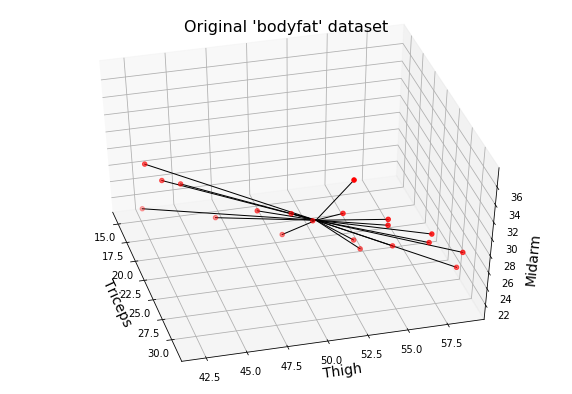

In [46]:
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(X[:,0], X[:,1], X[:,2],c='r')
ax1.set_xlabel('Triceps',fontsize=14)
ax1.set_ylabel('Thigh',fontsize=14)
ax1.set_zlabel('Midarm',fontsize=14)
ax1.set_title("Original 'bodyfat' dataset",fontsize=16)
ax1.view_init(elev=45., azim=-15)
for i in range(N):
    ax1.plot([X.mean(axis=0)[0],X[i,0]],[X.mean(axis=0)[1],X[i,1]],[X.mean(axis=0)[2],X[i,2]],\
            lw=1,c='k')
plt.show(block=True)

As can be seen in the figure, the observations are scattered more around the surface of a plane and not in space. <br>
Before moving on, let's save the weight vector for later usage.

In [47]:
w_=np.array(resultFat.params)[:,np.newaxis]
w_

array([[117.08469478],
       [  4.33409201],
       [ -2.85684794],
       [ -2.18606025]])

Do the same with the weight variance-covariance matrix. You may print the square root of the diagonal elements to compare with the OLS results above.

In [48]:
CovW=resultFat.cov_params()
np.sqrt(np.diag(CovW))

array([99.78240295,  3.01551136,  2.58201527,  1.595499  ])

Let's print out the OLS results of a model not containing the *Triceps* predictor.

In [49]:
resultFat2 = ols(formula = 'Fat ~ Thigh + Midarm', data=dataFat).fit()
print(resultFat2.summary(title='OLS Results for "bodyfat" dataset w. "Triceps" removed'))
print("\nRMSE =",np.sqrt(resultFat2.mse_resid))

            OLS Results for "bodyfat" dataset w. "Triceps" removed            
Dep. Variable:                    Fat   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     29.40
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           3.03e-06
Time:                        17:24:32   Log-Likelihood:                -45.527
No. Observations:                  20   AIC:                             97.05
Df Residuals:                      17   BIC:                             100.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.9970      6.997     -3.715      0.0

Although the R-squared value and the RMSE remained around the same, according to the t-statistic and the corresponding p-value, the regression coefficient for *Midarm* is zero. Let's try the other way around and remove *Thigh* predictor at this time.

In [50]:
resultFat2 = ols(formula = 'Fat ~ Triceps + Midarm', data=dataFat).fit()
print(resultFat2.summary(title='OLS Results for "bodyfat" dataset w. "Thigh" removed'))
print("\nRMSE =",np.sqrt(resultFat2.mse_resid))

             OLS Results for "bodyfat" dataset w. "Thigh" removed             
Dep. Variable:                    Fat   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     31.25
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           2.02e-06
Time:                        17:24:32   Log-Likelihood:                -45.050
No. Observations:                  20   AIC:                             96.10
Df Residuals:                      17   BIC:                             99.09
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7916      4.488      1.513      0.1

Although, now, the regression coefficients for both predictors seem to be significantly non-zero, for Midarm is negative, which is against our expectations. <br>
Finaly, print out the OLS results with *Midarm* predictor removed. 

In [51]:
resultFat2 = ols(formula = 'Fat ~ Triceps + Thigh', data=dataFat).fit()
print(resultFat2.summary(title='OLS Results for the original w. "Midarm" dataset'))
print("\nRMSE =",np.sqrt(resultFat2.mse_resid))

               OLS Results for the original w. "Midarm" dataset               
Dep. Variable:                    Fat   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     29.80
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           2.77e-06
Time:                        17:24:32   Log-Likelihood:                -45.422
No. Observations:                  20   AIC:                             96.84
Df Residuals:                      17   BIC:                             99.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.1742      8.361     -2.293      0.0

Although both predictors have positive regression coefficients, *Triceps* has significantly non-zero coefficients. <br> 
Thus, removing a predictor does not seem to be a good practice.

As a last step we may check the SLR for each predictor, first for *Triceps*.

In [52]:
resultFat3 = ols(formula = 'Fat ~ Triceps', data=dataFat).fit()
print(resultFat3.summary(title='OLS Results for the original w. "Midarm" dataset'))
print("\nRMSE =",np.sqrt(resultFat3.mse_resid))

               OLS Results for the original w. "Midarm" dataset               
Dep. Variable:                    Fat   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     44.30
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           3.02e-06
Time:                        17:24:32   Log-Likelihood:                -48.058
No. Observations:                  20   AIC:                             100.1
Df Residuals:                      18   BIC:                             102.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4961      3.319     -0.451      0.6

It seems that *Triceps* alone can provide a moderate result. Now, let's see *Thigh*.

In [53]:
resultFat3 = ols(formula = 'Fat ~ Thigh', data=dataFat).fit()
print(resultFat3.summary(title='OLS Results for the original w. "Midarm" dataset'))
print("\nRMSE =",np.sqrt(resultFat3.mse_resid))

               OLS Results for the original w. "Midarm" dataset               
Dep. Variable:                    Fat   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     60.62
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           3.60e-07
Time:                        17:24:32   Log-Likelihood:                -45.733
No. Observations:                  20   AIC:                             95.47
Df Residuals:                      18   BIC:                             97.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.6345      5.657     -4.178      0.0

*Thigh* predictor is even better and provide almost the same godness of fit measure as the model including all three predictors. Finally, let's see the *Midarm* predictor.

In [54]:
resultFat3 = ols(formula = 'Fat ~ Midarm', data=dataFat).fit()
print(resultFat3.summary(title='OLS Results for the original w. "Midarm" dataset'))
print("\nRMSE =",np.sqrt(resultFat3.mse_resid))

               OLS Results for the original w. "Midarm" dataset               
Dep. Variable:                    Fat   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.3728
Date:                Wed, 18 Nov 2020   Prob (F-statistic):              0.549
Time:                        17:24:32   Log-Likelihood:                -60.270
No. Observations:                  20   AIC:                             124.5
Df Residuals:                      18   BIC:                             126.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.6868      9.096      1.615      0.1

According to the F-statistic, the model, including the *Thigh* predictor, is not better than the mean of the output. The R-squared value is also close to zero, so we can discard this model. In conclusion, for this particular example, removing two out of the three predictors might be a reasonable choice. 

Now, let's see an alternative solution.

###  Principal Component Regression

So let's use the Principal Component Regression (PCR). <br>
First, we standardize the data using the *scikit-learn* library.

In [55]:
from sklearn.preprocessing import StandardScaler

Std=StandardScaler(with_mean=True,with_std=True)
Xo=Std.fit_transform(X)
N,D=Xo.shape

This is equivalent to the following linear transformation applied to the original design matrix (for more information, see the book).

In [56]:
Ao=np.zeros((D+1,D+1))
mean=X.mean(axis=0)
std=X.std(axis=0)
Ao[1:,1:]=np.diag(1/std)
Ao[0,1:]=-mean/std
Ao[0,0]=1
Ao

array([[  1.        ,  -5.16843386, -10.02926616,  -7.76977701],
       [  0.        ,   0.20424556,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.19599895,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.28130981]])

We may check the correctness of our linear transformation matrix by applying this linear transformation to the original design matrix and then comparing it with the design matrix of the standardized data.

In [57]:
np.sum(np.abs(Xdot@Ao-np.insert(Xo,0,np.ones(N),axis=1)))

2.6456267732122285e-14

And indeed, they are equal, except for the rounding error.

Now, let's create the OLS summary using the *statsmodels* library.

In [58]:
datao=pd.DataFrame(columns=['Triceps','Thigh','Midarm'], data=Xo)
datao['Fat']=dataFat['Fat']
resulto = ols(formula = 'Fat ~ Triceps + Thigh + Midarm', data=datao).fit()
print(resulto.summary(title='OLS Results for the original "bodyfat" dataset w. standardized data'))
print("\nRMSE =",np.sqrt(resulto.mse_resid))

     OLS Results for the original "bodyfat" dataset w. standardized data      
Dep. Variable:                    Fat   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     21.52
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           7.34e-06
Time:                        17:24:33   Log-Likelihood:                -44.312
No. Observations:                  20   AIC:                             96.62
Df Residuals:                      16   BIC:                             100.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.1950      0.555     36.418      0.0

The standardization did not change the t-statistic, so the same conclusion is drawn from the OLS results as before.

Before moving on, we may save the weight vector for comparison.

In [59]:
wo_=np.array(resulto.params)[:,np.newaxis]
wo_

array([[ 20.195     ],
       [ 21.22000615],
       [-14.57583303],
       [ -7.77100605]])

The weight vector (the vector of the estimated regression coefficients) can be also obtained by applying the inverse of the linear transformation on the original regression coefficients, as was derived in the book.

In [60]:
inv(Ao)@w_

array([[ 20.195     ],
       [ 21.22000615],
       [-14.57583303],
       [ -7.77100605]])

The covariance of the weight vector can be obtained using the linear transformation, as shown in the book. We can compare the obtained covariance matrix with the covariance of the OLS results. You may print out the square root of the diagonal elements to compare with the OLS results.

In [61]:
CovWo=inv(Ao)@CovW@inv(Ao).T
print(np.sum(np.abs(np.array(CovWo)-np.array(resulto.cov_params()))))
np.sqrt(np.diag(CovWo))

2.6326022269708864e-10


array([ 0.5545406 , 14.76414657, 13.17361802,  5.67167916])

Now, let's apply the PCA whitening to the standardized data.

In [62]:
Sigma=np.cov(Xo,rowvar=False,ddof=1)
lambda_,P=eigh(Sigma)
Lambda=np.eye(D,D)*lambda_
P=P@np.diag(np.sign(np.diag(P)))
W=P@np.sqrt(inv(Lambda))
W

array([[ 25.94564221,   0.05056546,   0.4710224 ],
       [-23.14619749,   0.4445516 ,   0.42676906],
       [ -9.92480341,  -0.90457468,   0.2360649 ]])

We may observe that the first eigenvalue is almost zero. That is, the eigenvalue of the first principal component (the first eigenvector) is close to zero.

In [63]:
Lambda

array([[7.64862504e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.81895476e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.17523440e+00]])

Let's create the transformed (whitened) data by using the whitening transformation matrix $\mathbf W$.

In [64]:
Z=Xo@W
Z

array([[ 1.71619589, -1.13971437, -1.1352082 ],
       [ 1.38979   , -0.27320878, -0.1342827 ],
       [-0.91055297, -2.26756416,  1.20298479],
       [-0.09534674, -0.56639537,  0.92534856],
       [-1.34604991, -1.68030228, -1.12943828],
       [ 0.12271015,  1.23842176, -0.00358229],
       [-0.89853669,  0.70671204,  1.19816394],
       [ 1.21257618, -0.65047489,  0.525335  ],
       [ 1.11771621,  0.98098085, -0.70808594],
       [-1.66370497,  0.92262402,  0.02638688],
       [-0.56939067, -0.07265418,  1.16975242],
       [ 0.01375455,  0.36142129,  0.99788155],
       [-0.91691109,  0.70051198, -1.33285918],
       [-0.81826877, -0.91457114, -1.05716012],
       [-0.65846691,  0.75965961, -2.15804497],
       [ 0.65315015, -0.30631481,  0.83844455],
       [-0.68396893,  0.87316291,  0.44836615],
       [ 0.66449541,  1.46642908,  0.89186137],
       [ 1.12097324, -0.15336265, -0.53357333],
       [ 0.54983588,  0.01463909, -0.0322902 ]])

We may visualize the observations of the whitened data in 3D.

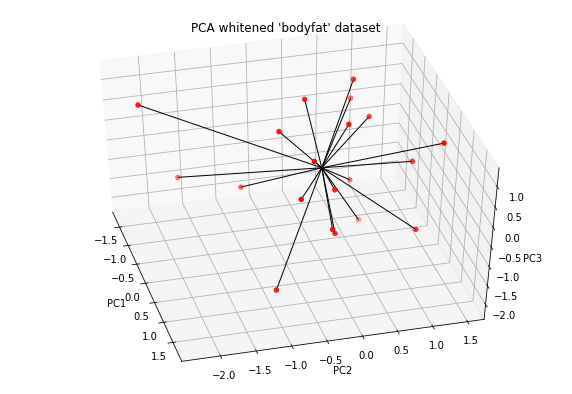

In [65]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2],c='r')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("PCA whitened 'bodyfat' dataset")
ax.view_init(elev=45., azim=-15)
for i in range(N):
    ax.plot([Z.mean(axis=0)[0],Z[i,0]],[Z.mean(axis=0)[1],Z[i,1]],[Z.mean(axis=0)[2],Z[i,2]],\
           c='k',lw=1)
plt.show(block=True)

Now, as can be seen from the figure, the observations are scattered in a volume and not around the surface of a plain.<br>
We may build up a new pandas dataframe using the principal components as the new features.

In [66]:
dataPCA=pd.DataFrame(columns=['PC1','PC2','PC3'], data=Z)
dataPCA['Fat']=dataFat['Fat']
dataPCA

,PC1,PC2,PC3,Fat
0,1.716196,-1.139714,-1.135208,11.9
1,1.389790,-0.273209,-0.134283,22.8
2,-0.910553,-2.267564,1.202985,18.7
3,-0.095347,-0.566395,0.925349,20.1
4,-1.346050,-1.680302,-1.129438,12.9
5,0.122710,1.238422,-0.003582,21.7
6,-0.898537,0.706712,1.198164,27.1
7,1.212576,-0.650475,0.525335,25.4
8,1.117716,0.980981,-0.708086,21.3
9,-1.663705,0.922624,0.026387,19.3


Then using the *statsmodels* library, we can print out the OLS results using the principal components.

In [67]:
resultPCA = ols(formula = 'Fat ~ PC1 + PC2 + PC3', data=dataPCA).fit()
print(resultPCA.summary(title='OLS Results for "bodyfat" dataset w. principal components'))
print("\nRMSE =",np.sqrt(resultPCA.mse_resid))

          OLS Results for "bodyfat" dataset w. principal components           
Dep. Variable:                    Fat   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     21.52
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           7.34e-06
Time:                        17:24:34   Log-Likelihood:                -44.312
No. Observations:                  20   AIC:                             96.62
Df Residuals:                      16   BIC:                             100.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.1950      0.555     36.418      0.0

As can be seen, the condition number is almost one. We may check the variance inflation factors, as well.

In [68]:
Zdot=np.insert(Z,0,np.ones(N),axis=1)
print(variance_inflation_factor(Zdot,1))
print(variance_inflation_factor(Zdot,2))
print(variance_inflation_factor(Zdot,3))

1.0
1.0000000000000002
1.0


And indeed, there is no correlation between the principal components as the VIF values are all equal to one.

If we check the t-statistic for each principal component, we may find out that the regression coefficient for the first principal component (*PC1*) significantly does not differ from zero. If you remember, the eigenvalue of this principal component was close to zero. Thus, we can remove this principal component from our model.

Before moving on, let's save the weight vector of this model for comparison.

In [69]:
wpca_=np.array(resultPCA.params)[:,np.newaxis]
wpca_

array([[20.195     ],
       [ 0.73814395],
       [ 1.59336571],
       [ 4.22021992]])

Let's create the linear transformation of the PCA whitening matrix, as described in the book.

In [70]:
Aw=np.zeros((D+1,D+1))
Aw[0,0]=1
Aw[1:,1:]=W
Aw

array([[  1.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  25.94564221,   0.05056546,   0.4710224 ],
       [  0.        , -23.14619749,   0.4445516 ,   0.42676906],
       [  0.        ,  -9.92480341,  -0.90457468,   0.2360649 ]])

Similarly to standardization, the design matrix of the whitened data can be obtained using this linear transformation. We can compare the results.

In [71]:
Xdoto=np.insert(Xo,0,np.ones(N),axis=1)
np.sum(np.abs(Zdot-Xdoto@Aw))

2.005947491445781e-14

And indeed, except for the rounding error, they are equal.<br>
We may also check that the hat matrix is not altered by the PCA whitening transformation.

In [72]:
Hx=Xdoto@inv(Xdoto.T@Xdoto)@Xdoto.T
Hz=Zdot@inv(Zdot.T@Zdot)@Zdot.T
np.sum(np.abs(Hx-Hz))

1.8914301819650953e-12

And indeed, except for the rounding error, they are equal. <br>
We may calculate the regression coefficients of the principal components by applying the inverse of this linear transformation.

In [73]:
inv(Aw)@wo_

array([[20.195     ],
       [ 0.73814395],
       [ 1.59336571],
       [ 4.22021992]])

But we may do it the other way around and calculate the weights of the unwhitened (original centered) data by applying the linear transformation to the weights of the transformed (whitened) data.

In [74]:
Aw@wpca_

array([[ 20.195     ],
       [ 21.22000615],
       [-14.57583303],
       [ -7.77100605]])

Or even find out the weights of the original (unstandardized) data by applying the linear transformation of both the standardization and whitening to the weight vector of the whitened data.

In [75]:
Ao@Aw@wpca_

array([[117.08469478],
       [  4.33409201],
       [ -2.85684794],
       [ -2.18606025]])

Similarly, we may calculate the covariance matrix of the weight vector of the whitened data, as shown in the book. We can compare the obtained covariance with the OLS result. We may also print out the square root of the diagonal elements of the covariance matrix in the above OLS results.

In [76]:
CovWpca=inv(Aw)@CovWo@inv(Aw).T
print(np.sum(np.abs(np.array(CovWpca)-np.array(resultPCA.cov_params()))))
np.sqrt(np.diag(CovWpca))

9.040036079766261e-12


array([0.5545406 , 0.56894665, 0.56894665, 0.56894665])

You may do it the other way around and calculate the covariance of the weights of the unwhitened data by applying the linear transformation to the covariance of the weight of the whitened data. 

In [77]:
np.sqrt(np.diag(Aw@np.array(resultPCA.cov_params())@Aw.T))

array([ 0.5545406 , 14.76414657, 13.17361802,  5.67167916])

Or even find out the standard error of the weights of the original data by applying the linear transformation of both whitening and standardization.

In [78]:
np.sqrt(np.diag(Ao@(Aw@np.array(resultPCA.cov_params())@Aw.T)@Ao.T))

array([99.78240295,  3.01551136,  2.58201527,  1.595499  ])

Finally, print out the OLS results of the model using only two principal components:

In [79]:
resultPCA = ols(formula = 'Fat ~ PC2 + PC3', data=dataPCA).fit()
print(resultPCA.summary(title='OLS Results for "bodyfat" dataset w. two principal components.'))
print("\nRMSE =",np.sqrt(resultPCA.mse_resid))

        OLS Results for "bodyfat" dataset w. two principal components.        
Dep. Variable:                    Fat   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     30.22
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           2.53e-06
Time:                        17:24:34   Log-Likelihood:                -45.313
No. Observations:                  20   AIC:                             96.63
Df Residuals:                      17   BIC:                             99.61
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.1950      0.566     35.707      0.0

Now, both the F-statistic and the individual t-statistic shows that our model is a good fit. Comparing the goodness of fit with the original model, we find that:
- adjusted R-squared value is 0.755 vs. 0.764 of the original model with high multicollinearity issue
- RMSE is 2.53 vs. 2.48

Next, let's see how we can obtain the weight vector of the original data using only two principal components.
First, we create the new linear transformation, but we set to zero the elements of the first eigenvector (first principal components).

In [80]:
Aw[:,1]=0
Aw

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.05056546,  0.4710224 ],
       [ 0.        ,  0.        ,  0.4445516 ,  0.42676906],
       [ 0.        ,  0.        , -0.90457468,  0.2360649 ]])

Then set the first weight corresponding to *PC1* to zero for the whitened data.

**Note:** *Elimination of variables in the orthogonal (whitened) model does not result in the elimination of variables in the original model*

In [81]:
wpca_[1,0]=0
wpca_

array([[20.195     ],
       [ 0.        ],
       [ 1.59336571],
       [ 4.22021992]])

Finally, apply the linear transformation of both the standardization and modified whitening to the weight vector of the whitened data to obtain the weight vector for the original data.

In [82]:
wnew_=Ao@Aw@wpca_
wnew_

array([[-12.20457544],
       [  0.42245894],
       [  0.4918383 ],
       [ -0.12520325]])

Thus, we obtained a model where at least two predictors are positive (*Triceps* and *Thigh*) and, although *Midarm* is still negative, in absolute value is less than in the original OLS model.

Moreover, calculating the standard errors, we may find that they provide very narrow confidence intervals.

In [83]:
CovWpcanew=np.insert(np.insert(np.array(resultPCA.cov_params()),1,[0,0,0],axis=1),1,[0,0,0,0],axis=0)
S_w_=np.sqrt(np.diag(Ao@(Aw@CovWpcanew@Aw.T)@Ao.T))[:,np.newaxis]
S_w_

array([[5.16929514],
       [0.05614487],
       [0.07008658],
       [0.15260325]])

We may check the R-squared value of the new model with new weight vectors using the R-squared metric from *scikit-learn* library:

In [84]:
from sklearn.metrics import r2_score
ypred_=wnew_[0,0]+wnew_[1,0]*X[:,0]+wnew_[2,0]*X[:,1]+wnew_[3,0]*X[:,2]
print('R-squared:',r2_score(y_,ypred_))
print('adj-R^2:',1-(1-r2_score(y_,ypred_))*(N-1)/(N-D))

R-squared: 0.7804613108797538
adj-R^2: 0.7546332298067837


And yes, the R-square value is the same as in the case of OLS using only two principal components (PC2 and PC3). <br>
We may also check the root mean square error.

In [85]:
from sklearn.metrics import mean_squared_error
np.sqrt(N/(N-D)*mean_squared_error(y_, ypred_))

2.529324037040148

The prediction can be done in two ways:
1. Transform the data first and apply the OLS w. only two principal components
2. Apply the back-transformed weights on the original data

As a comparison, we can also print out the prediction with the model using the original data.

In [86]:
xo=np.insert(np.array(dataFat.mean())[2:],0,1)[:,np.newaxis]
Aw[1:,1:]=W
print("Prediction w. 1st method:",xo.T@Ao@Aw@wpca_)
print("Prediction w. 2nd method:",xo.T@wnew_)
print("Prediction w. original model",xo.T@w_)

Prediction w. 1st method: [[20.195]]
Prediction w. 2nd method: [[20.195]]
Prediction w. original model [[20.195]]


Finally, let's define a function that will return a table with all the regression coefficients, standard deviation, t-statistic, p-value, and lower/upper confidence bounds using the linear transformations (standardization and whitening) as input.

In [87]:
def MLRresults(w_,S_w_,N,variables=[]):
    from scipy import stats
    D=len(variables)
    variables.insert(0,'Intercept')
    conflevel=95
    alpha=1-conflevel/100
    df=N-D-1
    tscore=abs(stats.t.ppf(alpha/2, df))
    table=pd.DataFrame(columns=["Input","Coefficient","Std. error","t-statistic","p-value","[0.025","0.975]"])
    for i in range(D+1):
        t_stat=w_[i,0]/S_w_[i,0]
        pval = stats.t.sf(np.abs(t_stat),df)*2
        LCL=w_[i,0]-tscore*S_w_[i,0]
        UCL=w_[i,0]+tscore*S_w_[i,0]
        table=table.append({"Input":variables[i],"Coefficient":w_[i,0],"Std. error":S_w_[i,0],
                            "t-statistic":t_stat,"p-value":pval,"[0.025":LCL,"0.975]":UCL},ignore_index=True)
    return table

Then, using that function, print out the result in a similar way as we would have with *statsmodels* library.

In [88]:
table=MLRresults(wnew_,S_w_,N,variables=['Triceps','Thigh','Midarm'])
pd.set_option("display.precision", 4)
table

,Input,Coefficient,Std. error,t-statistic,p-value,[0.025,0.975]
0,Intercept,-12.2046,5.1693,-2.3610,3.1249e-02,-23.1630,-1.2462
1,Triceps,0.4225,0.0561,7.5244,1.2167e-06,0.3034,0.5415
2,Thigh,0.4918,0.0701,7.0176,2.9050e-06,0.3433,0.6404
3,Midarm,-0.1252,0.1526,-0.8204,4.2402e-01,-0.4487,0.1983


With that, we can conclude that we obtain a better result using the principal component regression by using only two principal components than using the original data with only one predictor *Thigh*.

## 8. Case study: Body fat percentage <a name="PcentBodyFat"></a>

In the previous example, only a small sample has been used just to be able to visualize the whitening transformation and the back transformation better. In this part, we will use another body fat percentage dataset with more observations and more predictors. The goal is the same: we shall create a linear model, which can be used for predicting new observations.

### Multiple Linear Regression

Let's start with loading the dataset into a pandas dataframe and print out.

In [89]:
data=pd.read_csv(os.path.join('data','bodyfatpercentage.csv'),sep=' ')
data

,PcentBodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
5,20.9,24,210.25,74.75,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8
6,19.2,26,181.00,69.75,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7
7,12.4,25,176.00,72.50,37.8,99.6,88.5,97.1,60.0,39.4,23.2,30.5,29.0,18.8
8,4.1,25,191.00,74.00,38.1,100.9,82.5,99.9,62.9,38.3,23.8,35.9,31.1,18.2
9,11.7,23,198.25,73.50,42.1,99.6,88.6,104.1,63.1,41.7,25.0,35.6,30.0,19.2


Because the number of predictors is higher, we will use the *seaborn* heatmap to visualize the correlation matrix. With heatmap, we can immediately see which variables are highly correlated: dark blue represents high negative correlation, dark red high positive correlation, and white no correlation.

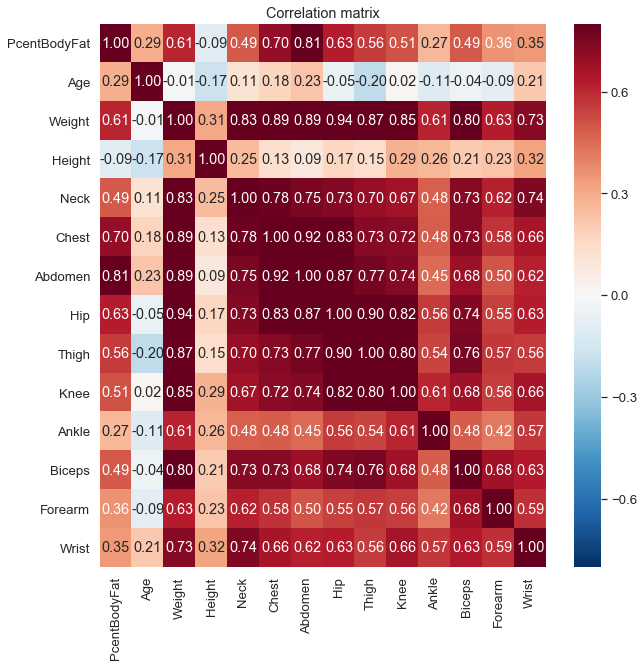

In [90]:
import seaborn as sns
corr_matrix=data[['PcentBodyFat','Age','Weight','Height','Neck','Chest','Abdomen','Hip','Thigh','Knee','Ankle','Biceps',\
         'Forearm','Wrist']].corr()
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
hm=sns.heatmap(data=corr_matrix, vmin=-0.8,vmax=+0.8,fmt='1.2f',annot=True,cmap="RdBu_r")
hm.set_xticklabels(hm.get_yticklabels(), rotation = 90)
plt.title('Correlation matrix')
plt.show()

As can be seen, the heatmap has very dark red areas, even in the off-diagonal regions, which indicates high positive correlations between predictors. Moreover, from the first row, we can also observe that not all predictors are correlated with the dependent variables. <br>
First, let see the OLS result involving all predictors.

In [91]:
result = ols(formula = 'PcentBodyFat ~ Age+Weight+Height+Neck+Chest+Abdomen+Hip+Thigh+Knee+Ankle+Biceps+Forearm+Wrist',\
             data=data).fit()
print(result.summary(title='OLS Results for "PcentBodyFat" dataset'))
print("\nRMSE =",np.sqrt(result.mse_resid))

                    OLS Results for "PcentBodyFat" dataset                    
Dep. Variable:           PcentBodyFat   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           7.72e-64
Time:                        17:24:37   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.1885     17.349     -1.048      0.2

The F-statistic shows that the model is a better one compared to the average of the dependent variable. According to the t-statistic, most of the input variables have coefficient significantly not different from zero. The condition number is also high, indicating the possibility of a multicollinearity issue.

Let's check the VIF values.

In [92]:
X=np.array(data.drop(columns='PcentBodyFat'))
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)
for i in range(1,14):
    print("VIF for "+data.drop(columns='PcentBodyFat').columns[i-1]+':',variance_inflation_factor(Xdot,i))

VIF for Age: 2.2504502358622362
VIF for Weight: 33.50931979124988
VIF for Height: 1.6745908395981155
VIF for Neck: 4.324463264249431
VIF for Chest: 9.460877321374252
VIF for Abdomen: 11.767073375321177
VIF for Hip: 14.796519836922984
VIF for Thigh: 7.777864692193444
VIF for Knee: 4.612146736004872
VIF for Ankle: 1.9079609950702072
VIF for Biceps: 3.6197435753654945
VIF for Forearm: 2.192492116664398
VIF for Wrist: 3.3775148961954473


As can be seen, the VIF values are high for around half of the predictors.<br>
As a first step, we may try to keep only those input variables in the linear model that has significantly nonzero regression coefficients according to the t-statistics.

In [93]:
resultRed = ols(formula = 'PcentBodyFat ~ Neck+Abdomen+Forearm+Wrist',\
             data=data).fit()
print(resultRed.summary(title='OLS Results for "PcentBodyFat" dataset'))
print("\nRMSE =",np.sqrt(resultRed.mse_resid))

                    OLS Results for "PcentBodyFat" dataset                    
Dep. Variable:           PcentBodyFat   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     154.1
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           6.80e-66
Time:                        17:24:37   Log-Likelihood:                -734.77
No. Observations:                 252   AIC:                             1480.
Df Residuals:                     247   BIC:                             1497.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.4679      5.959     -1.085      0.2

However, the *Forearm*, which previously did have regression coefficient significantly different from zero, now seems that does not play a significant role in the model predictability. So, we may try to remove that, as well.

In [94]:
resultRed = ols(formula = 'PcentBodyFat ~ Neck+Abdomen+Wrist-1',\
             data=data).fit()
print(resultRed.summary(title='OLS Results for "PcentBodyFat" dataset'))
print("\nRMSE =",np.sqrt(resultRed.mse_resid))

                         OLS Results for "PcentBodyFat" dataset                        
Dep. Variable:           PcentBodyFat   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              1708.
Date:                Wed, 18 Nov 2020   Prob (F-statistic):                   1.04e-165
Time:                        17:24:37   Log-Likelihood:                         -736.50
No. Observations:                 252   AIC:                                      1479.
Df Residuals:                     249   BIC:                                      1490.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

That is an interesting result because the R-squared value increased impressively up to 0.95 while the RMSE even increased slightly.

Now, let's see the alternative method.

### Principal Component Regression

Let's create the standardized data, as well as the linear transformation corresponding to the standardized data.

In [95]:
Xo=Std.fit_transform(X)
N,D=Xo.shape
Ao=np.zeros((D+1,D+1))
mean=X.mean(axis=0)
std=X.std(axis=0)
Ao[1:,1:]=np.diag(1/std)
Ao[0,1:]=-mean/std
Ao[0,0]=1

Then create the PCA whitened data, respective the linear transformation corresponding to PCA whitening.

In [96]:
Sigma=np.cov(Xo,rowvar=False,ddof=1)
lambda_,P=eigh(Sigma)
Lambda=np.eye(D,D)*lambda_
P=P@np.diag(np.sign(np.diag(P)))
W=P@np.sqrt(inv(Lambda))
Z=Xo@W
Aw=np.zeros((D+1,D+1))
Aw[0,0]=1
Aw[1:,1:]=W

We may check the eigenvalues of the principal components.

In [97]:
lambda_

array([0.02369908, 0.05718353, 0.07790004, 0.13468732, 0.1837103 ,
       0.26194401, 0.28730771, 0.31500428, 0.6011986 , 0.67015269,
       1.00631146, 1.36047448, 8.07221934])

As can be seen, none of the eigenvalues are close to zero.<br>
Let's print out the result of the OLS using all principal components.

In [98]:
    PCs=[]
    for i in range(1,14):
        PCs.append('PC'+str(i))
dataPCA=pd.DataFrame(columns=PCs, data=Z)
dataPCA['PcentBodyFat']=data['PcentBodyFat']
resultPCA = ols(formula = 'PcentBodyFat ~ PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10+PC11+PC12+PC13', data=dataPCA).fit()
print(resultPCA.summary(title='OLS Results for "bodyfat" dataset w. principal components'))
print("\nRMSE =",np.sqrt(resultPCA.mse_resid))

          OLS Results for "bodyfat" dataset w. principal components           
Dep. Variable:           PcentBodyFat   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           7.72e-64
Time:                        17:24:38   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1508      0.271     70.613      0.0

We obtained a model with no multicollinearity issue or conditioning problem, while the adjusted R-square or RMSE remains exactly the same. 

Because the linear transformation does not affect the hat matrix, and as a result, the predicted values - this have been proved in the book - it's not surprising.

Before moving on, let's save the weight vector.

In [99]:
wpca_=np.array(resultPCA.params)[:,np.newaxis]
wpca_

array([[19.15079365],
       [-0.29250158],
       [-2.13144846],
       [ 0.46003896],
       [-0.53898809],
       [ 0.34150566],
       [-0.19578086],
       [-1.78094579],
       [ 1.23913417],
       [ 1.17534649],
       [ 0.46158876],
       [ 1.72381434],
       [-3.30193446],
       [ 5.19601423]])

We will also save the covariance matrix of the weights.

In [100]:
CovW=np.array(resultPCA.cov_params())
np.sqrt(np.diag(CovW))

array([0.27120759, 0.2717473 , 0.2717473 , 0.2717473 , 0.2717473 ,
       0.2717473 , 0.2717473 , 0.2717473 , 0.2717473 , 0.2717473 ,
       0.2717473 , 0.2717473 , 0.2717473 , 0.2717473 ])

We may get back the original regression coefficient from the principal component (PC) regression coefficients using the two linear transformations (standardization and whitening).

In [101]:
Ao@Aw@wpca_

array([[-1.81884851e+01],
       [ 6.20786464e-02],
       [-8.84446759e-02],
       [-6.95904296e-02],
       [-4.70600014e-01],
       [-2.38641465e-02],
       [ 9.54773458e-01],
       [-2.07541123e-01],
       [ 2.36099845e-01],
       [ 1.52812146e-02],
       [ 1.73995368e-01],
       [ 1.81602416e-01],
       [ 4.52024914e-01],
       [-1.62063910e+00]])

Similarly, we can obtain the standard errors of the original weights using the covariance matrix of the weights of the principal components.

In [102]:
np.sqrt(np.diag(Ao@(Aw@CovW@Aw.T)@Ao.T))

array([17.34856624,  0.03234887,  0.05352552,  0.09600631,  0.23246731,
        0.09914684,  0.08644836,  0.1459103 ,  0.14435775,  0.24197733,
        0.22146628,  0.17112524,  0.19912891,  0.53494613])

Checking the *statsmodels* OLS summary, you may also find that -according to t-statistic - not all principal components have regression coefficients significantly different from zero. Moreover, this is not related to the smallest eigenvalues.

Let's print out the OLS of the reduced model using only principal components with significantly non-zero regression coefficients.

In [103]:
resultPCA = ols(formula = 'PcentBodyFat ~ PC2+PC7+PC8+PC9+PC11+PC12+PC13', data=dataPCA).fit()
print(resultPCA.summary(title='OLS Results for "bodyfat" dataset w. reduced set of principal components'))
print("\nRMSE =",np.sqrt(resultPCA.mse_resid))

   OLS Results for "bodyfat" dataset w. reduced set of principal components   
Dep. Variable:           PcentBodyFat   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     96.88
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           8.60e-67
Time:                        17:24:38   Log-Likelihood:                -724.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     244   BIC:                             1494.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1508      0.275     69.629      0.0

As can be seen, the adjusted R-squared value and RMSE remained almost the same, so the reduced principal component regression is a good model. Now, let's back transform the data to see what regression coefficients we obtain for the original predictors.

Let's see how the model will look like with the original predictors. For this, we create the linear transformation corresponding to PCA with reduced principal components first.

In [104]:
W[:,0]=0 
W[:,2:6]=0 
W[:,9]=0 
Aw=np.zeros((D+1,D+1))
Aw[0,0]=1
Aw[1:,1:]=W

Then we set to zero the weights of the removed principal components. 

In [105]:
wpca_[1,0]=0
wpca_[3:7,0]=0
wpca_[10,0]=0
wpca_

array([[19.15079365],
       [ 0.        ],
       [-2.13144846],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-1.78094579],
       [ 1.23913417],
       [ 1.17534649],
       [ 0.        ],
       [ 1.72381434],
       [-3.30193446],
       [ 5.19601423]])

Finally, apply the two linear transformations to the weight vector of the reduced principal components.

In [106]:
wnew_=Ao@Aw@wpca_
wnew_

array([[ 2.07784635],
       [ 0.03351164],
       [-0.02214661],
       [-0.21828644],
       [-0.16963074],
       [-0.09507707],
       [ 0.92696901],
       [-0.26415172],
       [-0.09624643],
       [ 0.34796123],
       [-0.10025153],
       [ 0.20145499],
       [ 0.63053698],
       [-2.1120145 ]])

Similarly, we set the covariances of the removed principal components and then apply the two linear transformations to obtain the standard errors of the original weights.

In [107]:
CovW[1,:]=0
CovW[:,1]=0
CovW[3:7,:]=0
CovW[:,3:7]=0
CovW[10,:]=0
CovW[:,10]=0
S_w_=np.sqrt(np.diag(Ao@(Aw@np.array(CovW)@Aw.T)@Ao.T))[:,np.newaxis]
S_w_

array([[6.71513699],
       [0.02510597],
       [0.00778031],
       [0.07853836],
       [0.11411794],
       [0.06241428],
       [0.08527118],
       [0.05605759],
       [0.03688988],
       [0.14348515],
       [0.1802142 ],
       [0.04219453],
       [0.13468653],
       [0.36174319]])

As can be seen above, the standard errors are lower for all estimated regression coefficients compared to the original model. We may print out the results in a format similar to what the *statsmodels* library provides.

In [108]:
variables=['Age','Weight','Height','Neck','Chest','Abdomen','Hip','Thigh','Knee','Ankle','Biceps','Forearm','Wrist']
table=MLRresults(wnew_,S_w_,N,variables=variables)
pd.set_option("display.precision", 4)
table

,Input,Coefficient,Std. error,t-statistic,p-value,[0.025,0.975]
0,Intercept,2.0778,6.7151,0.3094,7.5727e-01,-11.1508,15.3065
1,Age,0.0335,0.0251,1.3348,1.8321e-01,-0.0159,0.0830
2,Weight,-0.0221,0.0078,-2.8465,4.8061e-03,-0.0375,-0.0068
3,Height,-0.2183,0.0785,-2.7794,5.8816e-03,-0.3730,-0.0636
4,Neck,-0.1696,0.1141,-1.4865,1.3848e-01,-0.3944,0.0552
5,Chest,-0.0951,0.0624,-1.5233,1.2901e-01,-0.2180,0.0279
6,Abdomen,0.9270,0.0853,10.8708,1.2998e-22,0.7590,1.0950
7,Hip,-0.2642,0.0561,-4.7121,4.1711e-06,-0.3746,-0.1537
8,Thigh,-0.0962,0.0369,-2.6090,9.6553e-03,-0.1689,-0.0236
9,Knee,0.3480,0.1435,2.4251,1.6051e-02,0.0653,0.6306


We may also print out the adjusted R-squared, respective RMSE values.

In [109]:
ypred_=Xdot@wnew_
y_=np.array(data['PcentBodyFat'])[:,np.newaxis]
print('adj-R^2:',1-(1-r2_score(y_,ypred_))*(N-1)/(N-D))
print('RMSE:',np.sqrt(N/(N-D)*mean_squared_error(y_, ypred_)))

adj-R^2: 0.7221186196701115
RMSE: 4.411535928742535


### Using scikit-learn library

We may obtain similar results using the *PCA* method of *scikit-learn* library. First, we instantiate the PCA with full SVD (singular value decomposition) and whitening (i.e., the transformed data will have a unit covariance matrix.

In [110]:
from sklearn.decomposition import PCA
pca=PCA(whiten=True, svd_solver='full')
Z=pca.fit_transform(Xo)

Then print out the OLS results using *statsmodels* library:

In [111]:
PCs=[]
for i in range(1,14):
    PCs.append('PC'+str(i))
dataPCA=pd.DataFrame(columns=PCs, data=Z)
dataPCA['PcentBodyFat']=data['PcentBodyFat']
resultPCA = ols(formula = 'PcentBodyFat ~ PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10+PC11+PC12+PC13', data=dataPCA).fit()
print(resultPCA.summary(title='OLS Results for "bodyfat" dataset w. principal components'))
print("\nRMSE =",np.sqrt(resultPCA.mse_resid))

          OLS Results for "bodyfat" dataset w. principal components           
Dep. Variable:           PcentBodyFat   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           7.72e-64
Time:                        17:24:38   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1508      0.271     70.613      0.0

We can both plot and print out the explained variance ratio for each principal component.

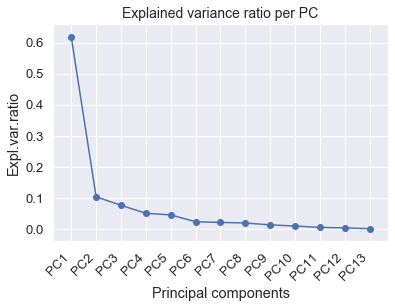

      Expl.var.ratio
PC1           0.6185
PC2           0.1042
PC3           0.0771
PC4           0.0513
PC5           0.0461
PC6           0.0241
PC7           0.0220
PC8           0.0201
PC9           0.0141
PC10          0.0103
PC11          0.0060
PC12          0.0044
PC13          0.0018


In [112]:
plt.plot(PCs,pca.explained_variance_ratio_)
plt.scatter(PCs,pca.explained_variance_ratio_)
plt.xticks(rotation=45, ha='right')
plt.title('Explained variance ratio per PC', fontsize=14)
plt.xlabel('Principal components')
plt.ylabel('Expl.var.ratio')
plt.show()
print(pd.DataFrame(index=PCs, columns=['Expl.var.ratio'],data=pca.explained_variance_ratio_))

The sum of the explained variance ratio should be one. Again, we can both plot and print out the cumulative sum of the explained variance ratio.

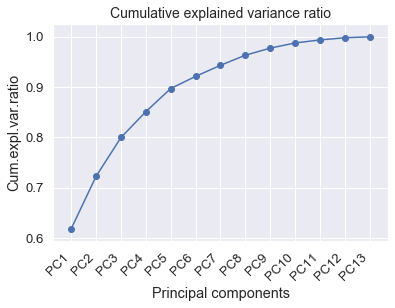

      Cum.expl.var.
PC1          0.6185
PC2          0.7227
PC3          0.7998
PC4          0.8512
PC5          0.8972
PC6          0.9214
PC7          0.9434
PC8          0.9634
PC9          0.9775
PC10         0.9878
PC11         0.9938
PC12         0.9982
PC13         1.0000


In [113]:
plt.plot(PCs,np.cumsum(pca.explained_variance_ratio_))
plt.scatter(PCs,np.cumsum(pca.explained_variance_ratio_))
plt.xticks(rotation=45, ha='right')
plt.title('Cumulative explained variance ratio', fontsize=14)
plt.xlabel('Principal components')
plt.ylabel('Cum.expl.var.ratio')
plt.show()
print(pd.DataFrame(index=PCs, columns=['Cum.expl.var.'],data=np.cumsum(pca.explained_variance_ratio_)))

Based on the plot and the printout, we can falsely conclude that using only the first seven principal components (explaining 95% of the variance of the original data) would be a good model.

In [114]:
resultPCA = ols(formula = 'PcentBodyFat ~ PC1+PC2+PC3+PC4+PC5+PC6+PC7', data=dataPCA).fit()
print(resultPCA.summary(title='OLS Results for "bodyfat" dataset w. principal components'))
print("\nRMSE =",np.sqrt(resultPCA.mse_resid))

          OLS Results for "bodyfat" dataset w. principal components           
Dep. Variable:           PcentBodyFat   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     71.93
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           9.25e-56
Time:                        17:24:39   Log-Likelihood:                -751.38
No. Observations:                 252   AIC:                             1519.
Df Residuals:                     244   BIC:                             1547.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1508      0.305     62.690      0.0

However, that would result in a suboptimal model. Using the t-statistic, a better model can be fit if PC12 is also used.

In [115]:
resultPCA = ols(formula = 'PcentBodyFat ~ PC1+PC2+PC3+PC5+PC6+PC7+PC12', data=dataPCA).fit()
print(resultPCA.summary(title='OLS Results for "bodyfat" dataset w. principal components'))
print("\nRMSE =",np.sqrt(resultPCA.mse_resid))

          OLS Results for "bodyfat" dataset w. principal components           
Dep. Variable:           PcentBodyFat   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     96.88
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           8.60e-67
Time:                        17:24:39   Log-Likelihood:                -724.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     244   BIC:                             1494.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1508      0.275     69.629      0.0

As can be seen, including PC12 - which has only 0.0044 explained variance ratio - in our model, better goodness of fit can be obtained (R-squared value increased while RMSE decreased).

You will get the same result if you leave out those columns of the whitened data that has a corresponding regression coefficient significantly not different from zero.

In [116]:
resultPCA = ols(formula = 'PcentBodyFat ~ PC1+PC2+PC3+PC5+PC6+PC7+PC12', data=\
                dataPCA.drop(['PC4','PC8','PC9','PC10','PC11','PC13'],axis=1)).fit()
print(resultPCA.summary(title='OLS Results for "bodyfat" dataset w. principal components'))
print("\nRMSE =",np.sqrt(resultPCA.mse_resid))

          OLS Results for "bodyfat" dataset w. principal components           
Dep. Variable:           PcentBodyFat   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     96.88
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           8.60e-67
Time:                        17:24:39   Log-Likelihood:                -724.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     244   BIC:                             1494.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1508      0.275     69.629      0.0

Finally, we may also use the pipeline of the *scikit-learn* library to have with only one single line of code: the standardizing transformation, the whitening transformation, and the linear regression model fit.

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
# Creating the pipeline for standardization, PCA whitening, and linear regression
pipe = Pipeline([('standardizer', StandardScaler(with_mean=True,with_std=True)), ('pca', PCA(whiten=True, svd_solver='full')),\
                ('linregr',LinearRegression())])
# Using the newly created pipeline to fit the data
pipe.fit(X,y_)
# Print out the R-squared value and the regression coefficients.
print(pd.DataFrame(index=PCs, columns=['Regr coef'],data=pipe['linregr'].coef_.T))
print("\nR-squared =",pipe.score(X,y_))

      Regr coef
PC1      5.1960
PC2      3.3019
PC3      1.7238
PC4      0.4616
PC5     -1.1753
PC6     -1.2391
PC7      1.7809
PC8      0.1958
PC9      0.3415
PC10     0.5390
PC11    -0.4600
PC12     2.1314
PC13     0.2925

R-squared = 0.749049969148275


As can be seen, the same result is obtained using the pipeline as with instantiating and applying each method independently on the data. This pipelining will be useful during cross-validation in later lab exercises.

<img src = "images/AML1-Cover.png" width = 110, align = "left" style="margin:0px 20px">

<span style="color:blue">**Note:**</span> This Jupyter Notebook is accompanying the book: <br> $\qquad$ <b>Advanced Machine Learning Made Easy</b> <br> $\qquad$ From Theory to Practice with NumPy and scikit-learn <br> $\qquad$ <i> Volume 1: Generalized Linear Models</i><br>
by Ferenc Farkas, Ph.D. 

If you find this Notebook useful, please support me by buying the book at [Leanpub](http://leanpub.com/AML1). <br>
Copyright notice: This Jupyter Notebook is made available under the [MIT License](https://opensource.org/licenses/MIT).